In [1]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1

import sys, os
sys.path.insert(0, os.path.abspath("../.."))
import matplotlib.pyplot as plt
import pandas as pd

import pygimli as pg
import numpy as np


from fpinv import set_style
fs = 5.5
set_style(fs, style="seaborn-dark")

In [2]:
day = "2014-08-19 00:00:00"
sch5000 = pd.read_csv("./SCH_5000.csv", skiprows=4, parse_dates=True)
sch5198 = pd.read_csv("./SCH_5198.csv", skiprows=4, parse_dates=True)
sch5000 = sch5000.set_index("Time").T[day].rename("sch5000")
sch5198 = sch5198.set_index("Time").T[day].rename("sch5198")
zusammen = pd.concat([sch5000, sch5198], axis=1, sort=True)

In [3]:
mesh = pg.load("paraDomain_1.bms")
joint = np.load("joint_inversion_1.npz")

mesh2 = pg.load("paraDomain_2.bms")
joint2 = np.load("joint_inversion_2.npz")

conv = np.load("conventional.npz")

bl1 = {
    "name": "SCH_5198",
    "depth": 0.15,
    "pos": 10,
    "temp": np.column_stack((sch5198, np.asarray(sch5198.index, dtype="float"))),
    "templim": (-0.5, 3.5),
    "alt": 2.0,
    "figname": "Fig6_two_columns.pdf"
}

bl2 = {
    "name": "SCH_5000",
    "depth": 0.65,
    "pos": 26,
    "temp": np.column_stack((sch5000, np.asarray(sch5000.index, dtype="float"))),
    "templim": (-0.2, 0.7),
    "alt": 2.2,
    "figname": "Fig7_two_columns.pdf"
}

def interpolate(mesh, data, x, y):
    result = []
    for yi in y:
        cell = mesh.findCell(pg.Pos(x[0], yi))
        result.append(data[cell.id()])
    return np.array(result)
        

def get(mesh, data, frac, bl):
    quant = data[frac]
    if "fr" in data:
        fr = data["fr"]
    else:
        fr = np.ones_like(data["fw"]) * (1 - 0.53)

    y = np.linspace(-12, -bl["depth"], 100)
    #profile = pg.interpolate(mesh, quant, x=np.ones_like(y) * bl["pos"], y=y)
    #fr_profile = pg.interpolate(mesh, fr, x=np.ones_like(y) * bl["pos"], y=y)
    profile = interpolate(mesh, quant, x=np.ones_like(y) * bl["pos"], y=y)
    fr_profile = interpolate(mesh, fr, x=np.ones_like(y) * bl["pos"], y=y)
    y += bl["depth"]
    if frac != "fr":
        profile /= (1-fr_profile)
    return (profile, -y)

short = ["T $\degree$C"]
short.extend([r"f$_{\rm %s}$ / (1 - f$_{\rm r}$)" % x for x in "wia"])
short.append(r"f$_{\rm r}$")
long = "     Temperature\n", "Water\nsaturation", "Ice\nsaturation", "Air\nsaturation", "Rock\ncontent"
colors = ["xkcd:red", "#0e59a2", "#684da1", "#127c39", "#bd3e02"]

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


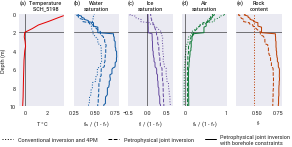

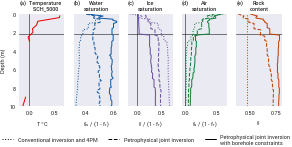

In [4]:
for bl in bl1, bl2:
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(4.7, 1.7))
    
    for ax, s, l, b in zip(axs, short, long, "abcde"):
        ax.axhline(bl["alt"], c="k", alpha=0.5)
        ax.set_xlabel(s)
        if b == "a":
            l += "     " + bl["name"]
        ax.set_title(l, fontsize=fs)  
        ax.set_title("(%s)\n" % b, loc="left", fontsize=fs)
     
    temp = bl["temp"]

    axs[0].axvline(0, c="k", ls="-", alpha=0.5)
    axs[0].set_ylabel("Depth (m)")
    axs[0].set_ylim(10, 0)
    axs[0].set_xlim(*bl["templim"])
    
    axs[0].plot(temp[:,0], temp[:,1], "-", c=colors[0])
    
    for i, (ax, quant) in enumerate(zip(axs[1:], "wiar")):
        
        if quant == "r":
            ax.axvline(1 - 0.53, c=colors[i + 1], ls=":")        
        else:
            ax.plot(*get(mesh, conv, "f" + quant, bl), ":", c=colors[i + 1])
            
        ax.plot(*get(mesh, joint, "f" + quant, bl), "--", c=colors[i + 1])
        ax.plot(*get(mesh2, joint2, "f" + quant, bl), "-", c=colors[i + 1])
        
        if quant in "ia":
            ax.axvline(0, c="k", ls="-", alpha=0.5)
    
    ax.plot([], [], "k:", label="Conventional inversion and 4PM")
    ax.plot([], [], "k--", label="Petrophysical joint inversion")
    ax.plot([], [], "k-", label="Petrophysical joint inversion\nwith borehole constraints")
    plt.legend(bbox_to_anchor=(0.5, -.23), bbox_transform=plt.gcf().transFigure, ncol=3,
               frameon=False, loc="lower center")

    fig.savefig(bl["figname"])
    fig.show()